# Cluster Analysis on Prison Cases By State

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Data Preprocessing

In [2]:
# Read in population data and fillna using OLS
pop = pd.read_csv('clean_data/population.csv').drop(['prison_pop_date','staff_pop_date','abbreviation'], 1)

# Fillin the nan values using a linear model
from sklearn.linear_model import LinearRegression
train = pop[pop['staff_pop']>0].copy()
test = pop[pop['staff_pop'].isna()].copy()
X_train, X_test, y_train = train[['prison_pop']], test[['prison_pop']], train['staff_pop']
ols = LinearRegression().fit(X_train, y_train)
y_pred = ols.predict(X_test)
y_pred = list(map(int, y_pred))
pop.loc[pop['staff_pop'].isnull(), 'staff_pop'] = y_pred

pop.head()

,name,prison_pop,staff_pop
0,Alabama,21154,6259.0
1,Alaska,4997,1971.0
2,Arizona,41674,8536.0
3,Arkansas,18181,4045.0
4,California,118466,46000.0


In [3]:
''' define_awareness aims at better categorized the noisy data, 
    higher value means higher administrative awareness,
    7 stands for an estimated R0 (rate of disease Transmission), 
    prisons with extensive number of testing is the highest ranks "3",
    prisons with prisoner testings and staff testings ranks "2",
    prisons with only prisoner testing information ranks "1".
    prison with no testings information ranks "0".
    Notes:Due to the limitation of this dataset, NaN does not necessrily 
    stands for no tests has been conducted, but more likely no information
    has been released to public. However, limited information released during 
    COVID could mean that the shortage in administration.'''

def define_awareness(row):
    if (row['prisoner_tests']+row['staff_tests'])/(row['total_prisoner_cases']+row['total_staff_cases']) > 7 :
        val = 3
    elif row['prisoner_tests']>0 and row['staff_tests']>0 :
        val = 2
    elif row['prisoner_tests']>0 :
        val = 1
    else:
        val = 0
    return val

In [4]:
# Read in covid cases data and handle 
df = pd.read_csv('data/covid_prison_cases.csv')

# Generate New Feature for Staff_tests
df['date'] = pd.to_datetime(df['as_of_date'])
df = df.set_index('date', drop= 1).drop(['notes','as_of_date','abbreviation'], 1)

In [5]:
# Check on most recent staticstic
lately_covid = []
for state in df.name.unique():
    lately_covid.append(df[df['name'] == state].iloc[0])
    
lately_covid = pd.DataFrame(lately_covid).set_index('name',drop=1)
#lately_covid['has_staff_death'] = np.where(lately_covid.total_staff_deaths != 0, 1, 0)  
#lately_covid['has_prn_death'] = np.where(lately_covid.total_prisoner_deaths != 0, 1, 0)  
#lately_covid['testing_awearness'] = lately_covid.apply(define_awareness,1)
#lately_covid = lately_covid.drop(['staff_tests','total_staff_deaths'],1)
lately_covid.head()

,staff_tests,prisoner_tests,total_staff_cases,total_prisoner_cases,total_staff_deaths,total_prisoner_deaths
name,,,,,,
Alabama,NaN,102.0,17.0,8.0,0.0,1.0
Alaska,NaN,235.0,8.0,1.0,0.0,0.0
Arizona,NaN,277.0,52.0,69.0,0.0,5.0
Arkansas,NaN,NaN,127.0,944.0,0.0,5.0
California,NaN,1551.0,169.0,398.0,0.0,1.0


In [6]:
lately_covid['total_staff_deaths'].fillna(0, inplace=True)
lately_covid['total_prisoner_deaths'].fillna(0, inplace=True)

In [7]:
prison_covid = pop.merge(lately_covid,on='name').set_index('name')
prison_covid.head()

,prison_pop,staff_pop,staff_tests,prisoner_tests,total_staff_cases,total_prisoner_cases,total_staff_deaths,total_prisoner_deaths
name,,,,,,,,
Alabama,21154,6259.0,NaN,102.0,17.0,8.0,0.0,1.0
Alaska,4997,1971.0,NaN,235.0,8.0,1.0,0.0,0.0
Arizona,41674,8536.0,NaN,277.0,52.0,69.0,0.0,5.0
Arkansas,18181,4045.0,NaN,NaN,127.0,944.0,0.0,5.0
California,118466,46000.0,NaN,1551.0,169.0,398.0,0.0,1.0


In [9]:
prison_covid['prisoner_positive_rate'] = prison_covid['total_prisoner_cases']/prison_covid['prisoner_tests']
prison_covid['prisoner_positive_rate'].fillna(prison_covid['prisoner_positive_rate'].mean(), inplace=True)

prison_covid['prisoner_test_prop'] = prison_covid['prisoner_tests']/prison_covid['prison_pop']
prison_covid['staff_test_prop'] = prison_covid['staff_tests']/prison_covid['staff_pop']

In [10]:
prison_covid['prisoner_pos_prop'] = prison_covid['total_prisoner_cases']/prison_covid['prisoner_tests']
prison_covid['staff_pos_prop'] = prison_covid['total_staff_cases']/prison_covid['staff_tests']

prison_covid['prisoner_affected_prop'] = prison_covid['total_prisoner_cases']/prison_covid['prison_pop']
prison_covid['staff_affected_prop'] = prison_covid['total_staff_cases']/prison_covid['staff_pop']

prison_covid['prisoner_death_prop'] = prison_covid['total_prisoner_deaths']/prison_covid['total_prisoner_cases']
prison_covid['staff_death_prop'] = prison_covid['total_staff_deaths']/prison_covid['total_staff_cases']

In [11]:
prison_covid['prisoner_death_prop'].fillna(0, inplace=True)
prison_covid['staff_death_prop'].fillna(0, inplace=True)

prison_covid['staff_positive_rate'] = prison_covid['total_staff_cases']/prison_covid['staff_tests']
# prison_covid['prisoner_positive_rate'].fillna(prison_covid['prisoner_positive_rate'].mean(), inplace=True)

## Classification

In [11]:
# X = prison_covid
# X = lately_covid
# scaler = StandardScaler()
# X_std = scaler.fit_transform(X)

In [22]:
X_std = prison_covid[['prisoner_positive_rate','prisoner_affected_prop','staff_affected_prop','prisoner_death_prop','staff_death_prop']]

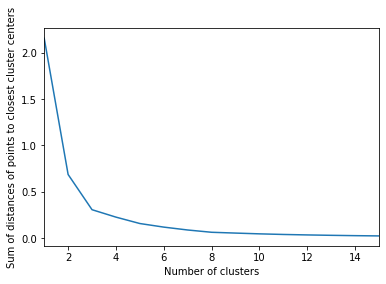

In [13]:
sum_of_distances = {}
for num_clusters in range(1,16):
    kmeans = KMeans(n_clusters=num_clusters, random_state=1)
    kmeans.fit(X_std)
    sum_of_distances[num_clusters] = kmeans.inertia_
pd.Series(sum_of_distances).sort_index().plot()
plt.xlabel('Number of clusters')
plt.ylabel('Sum of distances of points to closest cluster centers')
plt.show()

In [14]:
sum_of_distances

{1: 2.154440979200546,
 2: 0.6841991683843935,
 3: 0.3041286861852251,
 4: 0.2240538390204153,
 5: 0.1549274790357733,
 6: 0.11624329215948559,
 7: 0.08515415636559032,
 8: 0.06054592592035897,
 9: 0.051837021340922815,
 10: 0.04354249118090342,
 11: 0.036965246850805246,
 12: 0.03190788194450159,
 13: 0.027662004105598256,
 14: 0.024074774523510235,
 15: 0.021250875260954517}

In [15]:
model = KMeans(n_clusters=3, random_state=1)
model.fit(X_std)

lately_covid['classified_result'] = model.labels_
lately_covid['classified_result'].value_counts()

1    21
0    21
2     9
Name: classified_result, dtype: int64

In [18]:
X_std['classified_result'] = model.predict(X_std)

G:\Anaconda2\envs\Python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
X_std[X_std['classified_result'] == 0]

,prisoner_positive_rate,prisoner_affected_prop,staff_affected_prop,prisoner_death_prop,staff_death_prop,classified_result
name,,,,,,
Arizona,0.249097,0.001656,0.006092,0.072464,0.000000,0
Arkansas,0.210908,0.051922,0.031397,0.005297,0.000000,0
California,0.256609,0.003360,0.003674,0.002513,0.000000,0
Colorado,0.290534,0.017804,0.003989,0.003226,0.000000,0
Connecticut,0.210908,0.039123,0.058023,0.012552,0.000000,0
Georgia,0.210908,0.005775,0.011906,0.031646,0.010000,0
Illinois,0.293333,0.004769,0.013327,0.068182,0.000000,0
Kansas,0.210908,0.062184,0.029740,0.004878,0.000000,0
Kentucky,0.210908,0.028858,0.013761,0.005882,0.000000,0


In [20]:
X_std[X_std['classified_result'] == 1]

,prisoner_positive_rate,prisoner_affected_prop,staff_affected_prop,prisoner_death_prop,staff_death_prop,classified_result
name,,,,,,
Alabama,0.078431,0.000378,0.002716,0.12500,0.0,1
Alaska,0.004255,0.000200,0.004059,0.00000,0.0,1
Hawaii,0.000000,0.000000,0.000000,0.00000,0.0,1
Idaho,0.000000,0.000000,0.002501,0.00000,0.0,1
Iowa,0.048499,0.002500,0.004453,0.00000,0.0,1
Maine,0.000000,0.000000,0.000884,0.00000,0.0,1
Mississippi,0.108108,0.000214,0.011844,0.25000,0.0,1
Missouri,0.084211,0.001231,0.001818,0.03125,0.0,1
Nevada,0.000000,0.000000,0.005714,0.00000,0.0,1


In [21]:
X_std[X_std['classified_result'] == 2]

,prisoner_positive_rate,prisoner_affected_prop,staff_affected_prop,prisoner_death_prop,staff_death_prop,classified_result
name,,,,,,
Delaware,0.468165,0.027033,0.025296,0.024000,0.000000,2
Florida,0.488199,0.004280,0.008102,0.017812,0.000000,2
Indiana,0.592417,0.018594,0.039000,0.026000,0.008547,2
New Jersey,0.778986,0.011883,0.071767,0.176744,0.003478,2
New York,0.670436,0.009700,0.059771,0.036145,0.003500,2
North Carolina,0.508104,0.018556,0.003730,0.006380,0.000000,2
Ohio,0.622941,0.088424,0.039616,0.009740,0.004141,2
Pennsylvania,0.437309,0.003243,0.008426,0.020979,0.000000,2
Texas,0.626054,0.009534,0.013972,0.017216,0.009921,2


In [37]:
from sklearn.metrics import euclidean_distances

In [38]:
similarities = euclidean_distances(X_std)

In [39]:
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity='precomputed')
pos = mds.fit(similarities).embedding_

No handles with labels found to put in legend.


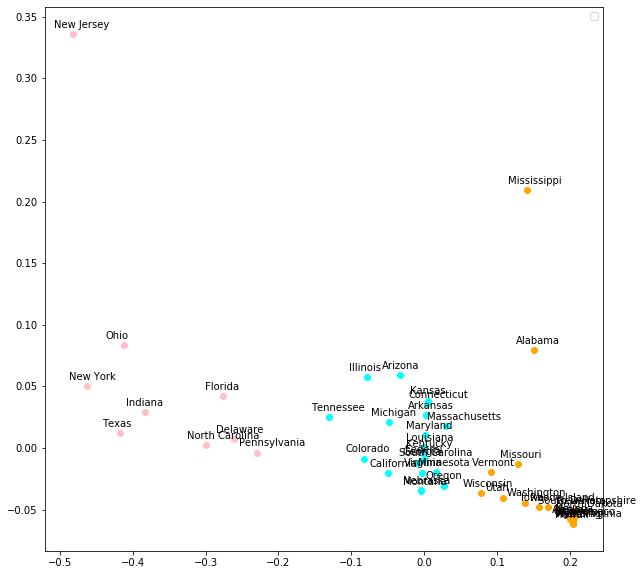

In [60]:
fig, ax = plt.subplots(figsize=(10,10))
colors = ['cyan','orange','pink']
for i in range(len(pos)):
    ax.scatter(pos[i][0], pos[i][1], color=colors[model.labels_[i]])
    plt.text(pos[i][0]-0.025, pos[i][1]+0.005, X_std.index[i])
ax.legend()
plt.show()

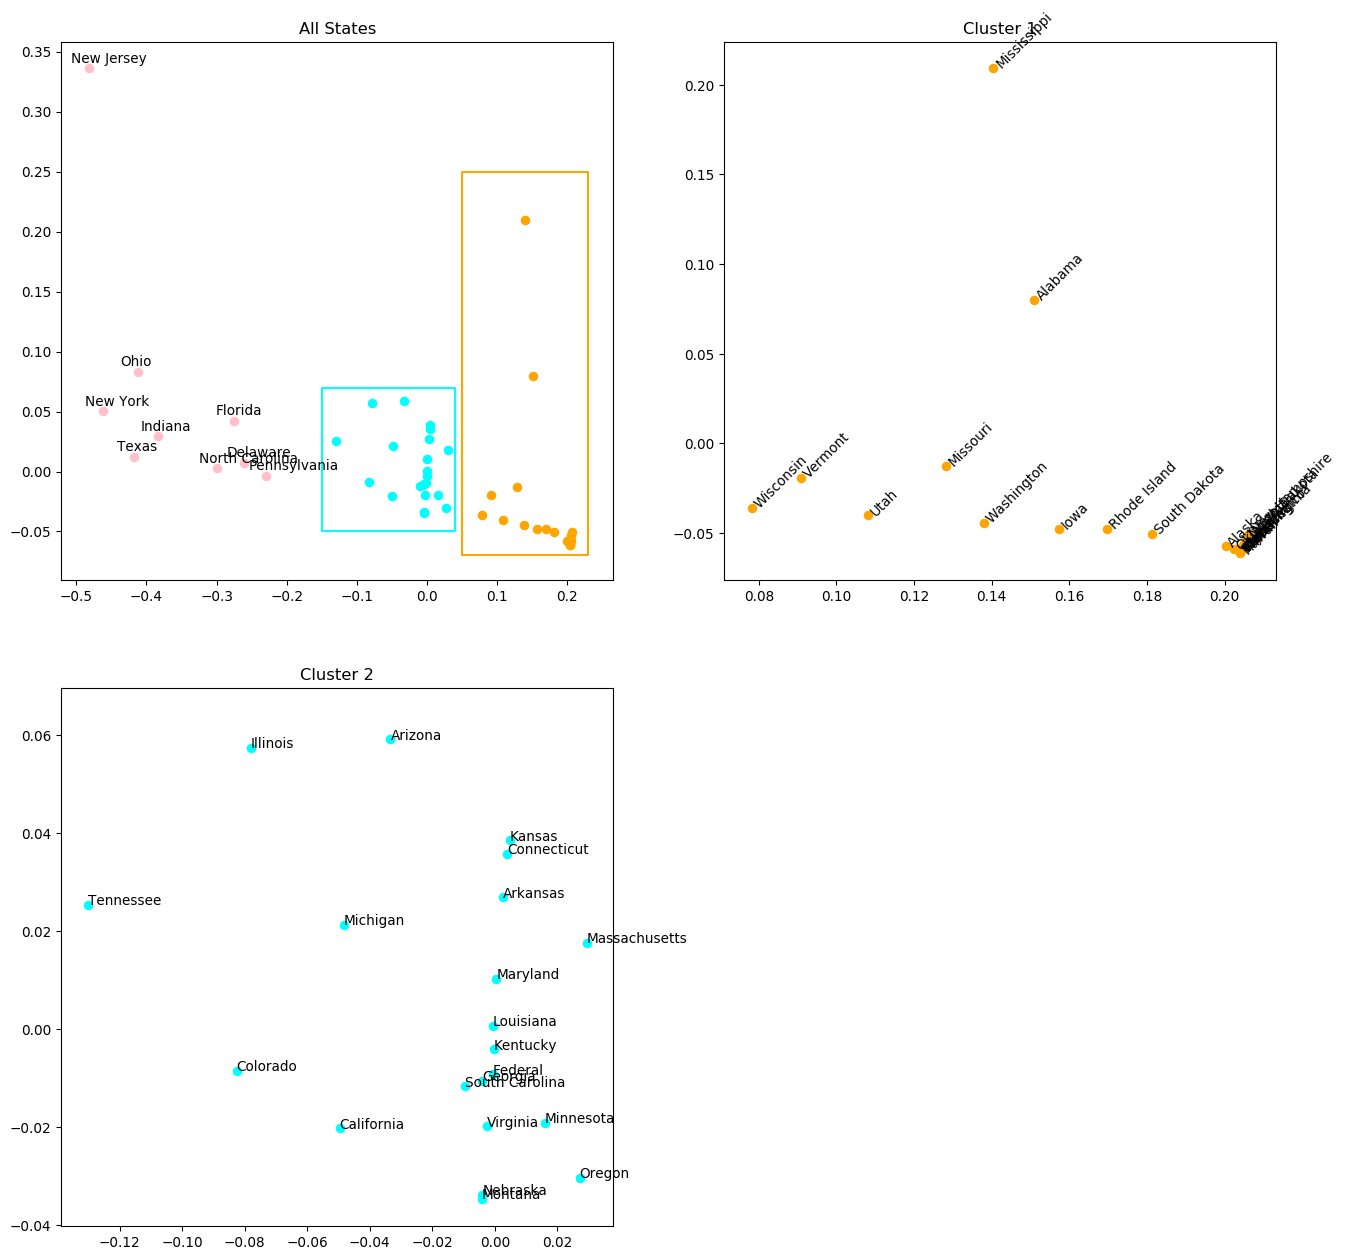

In [90]:
from matplotlib.patches import ConnectionPatch
 
plt.figure(figsize=(16,16),dpi=98)
p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)

colors = ['cyan','orange','pink']
for i in range(len(pos)):
    p1.scatter(pos[i][0], pos[i][1], color=colors[model.labels_[i]])
    if model.labels_[i] == 2:
        p1.text(pos[i][0]-0.025, pos[i][1]+0.005, X_std.index[i])

for i in range(len(pos)):
    if model.labels_[i] == 1:
        p2.scatter(pos[i][0], pos[i][1], color=colors[1])
        p2.text(pos[i][0], pos[i][1], X_std.index[i], rotation=45)

for i in range(len(pos)):
    if model.labels_[i] == 0:
        p3.scatter(pos[i][0], pos[i][1], color=colors[0])
        p3.text(pos[i][0], pos[i][1], X_std.index[i])

p1.set_title("All States",fontsize=12)
p2.set_title("Cluster 1", fontsize=12)
p3.set_title("Cluster 2", fontsize=12)
 
# plot the box
tx0 = -0.15
tx1 = 0.04
ty0 = -0.05
ty1 = 0.07
sx = [tx0,tx1,tx1,tx0,tx0]
sy = [ty0,ty0,ty1,ty1,ty0]
p1.plot(sx,sy,"cyan")

tx0 = 0.05
tx1 = 0.23
ty0 = -0.07
ty1 = 0.25
sx = [tx0,tx1,tx1,tx0,tx0]
sy = [ty0,ty0,ty1,ty1,ty0]
p1.plot(sx,sy,"orange")
 

plt.show()